In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='31369a67-2b28-463a-905a-20f189d4d327', project_access_token='p-f53a1432b7858ffe0da0f7a9b2614ee8e1206a82')
pc = project.project_context


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster

In [5]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_047ce949bca940b6a7875ce494954161 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_047ce949bca940b6a7875ce494954161 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_047ce949bca940b6a7875ce494954161 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='bOca-tT0NYGXm0LrhvvRmw3QisI_f-ftNjJTzEVrM9Uj',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_047ce949bca940b6a7875ce494954161)

body = client_047ce949bca940b6a7875ce494954161.get_object(Bucket='papure-donotdelete-pr-jkgjellgwtmnsl',Key='subjacente.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

datos = pd.read_csv(body)
datos.head()


,fecha,y
0,01/01/2000,48.801160
1,15/01/2000,49.137179
2,01/02/2000,49.413209
3,15/02/2000,49.602727
4,01/03/2000,49.756948


In [6]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'y': 'y'})
datos = datos.asfreq('SMS')
datos.replace(r'^\s*$', np.nan, regex=True)
datos.fillna(datos.mean())
datos = datos['y'] 
datos = datos.sort_index()

#write_eval_CSV=datos
#project.save_data('guarda.csv', write_eval_CSV.to_csv(), overwrite=True)

In [7]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

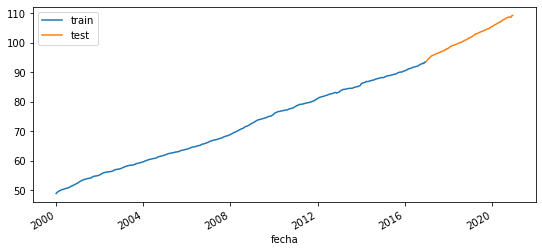

In [8]:
# Separación datos train-test
# ==============================================================================
steps = 96
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [9]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags=12
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Exogenous variable: False, None
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

In [10]:
# Predicciones
# ==============================================================================
steps = 96
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

fecha
2017-01-01    91.693382
2017-01-15    91.676063
2017-02-01    91.654896
2017-02-15    91.622885
2017-03-01    91.582724
Freq: SMS-15, dtype: float64

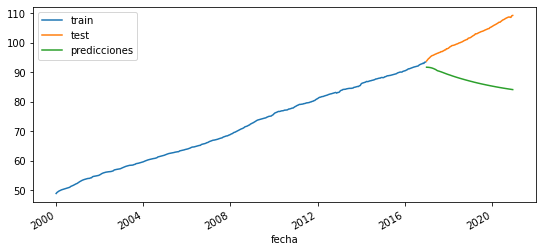

In [11]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [12]:
error_mse = mean_absolute_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 14.410317480535449


In [13]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags      = 12 # Este valor será remplazado en el grid search
                )

param_grid = {'alpha': np.logspace(-3, 3, 10)}

lags_grid = [6, 12, 18, 24, 30, 36]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 96,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-08-29 16:46:26,195 root       INFO  Number of models to fit: 60
loop lags_grid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]   
2021-08-29 16:46:27,410 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
params: {'alpha': 0.001}



In [14]:
# Resultados Grid Search
# ==============================================================================
resultados_grid
#write_eval_CSV=resultados_grid
#project.save_data('resultados_grid.csv', write_eval_CSV.to_csv(), overwrite=True)

,lags,params,metric
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},1.563047
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},1.578787
41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},1.862882
0,"[1, 2, 3, 4, 5, 6]",{'alpha': 0.001},2.210202
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.001},2.258135
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},2.369308
1,"[1, 2, 3, 4, 5, 6]",{'alpha': 0.004641588833612777},2.373979
51,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},2.462699
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318832},2.541534
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},2.707604


In [15]:
forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: Ridge(alpha=0.001, normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Exogenous variable: False, None
Parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

In [16]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

fecha
2017-01-01    93.432890
2017-01-15    93.541733
2017-02-01    93.651209
2017-02-15    93.758016
2017-03-01    93.868495
Freq: SMS-15, dtype: float64

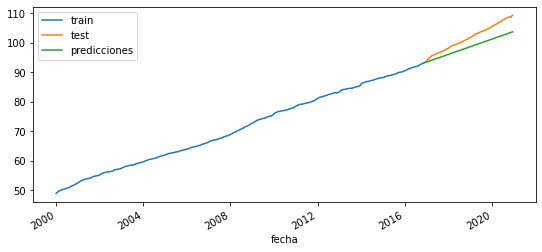

In [17]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [18]:
error_mse = mean_absolute_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 3.2125859454859245


In [19]:
from statsmodels.tsa.ar_model import AutoReg
lags = 15

modelo_ar = AutoReg(datos_train, lags=lags)
res = modelo_ar.fit()

# Predicciones
# ==============================================================================
predicciones_statsmodels = res.predict(start=datos_test.index[0], end=datos_test.index[-1])
predicciones_statsmodels.head()

2021-08-29 16:46:27,847 numexpr.utils INFO  Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


2017-01-01    93.648820
2017-01-15    93.723469
2017-02-01    93.888522
2017-02-15    93.898330
2017-03-01    94.114142
Freq: SMS-15, dtype: float64

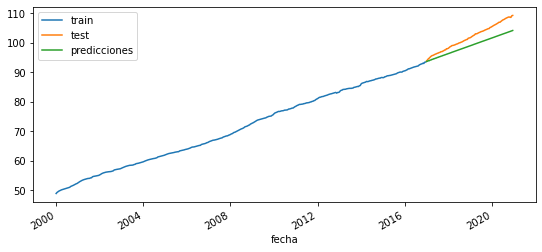

In [20]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='predicciones')
ax.legend();

In [21]:
df = pd.DataFrame({'fecha': ['2021-01-01', '2021-01-15', '2021-02-01', '2021-02-15','2021-03-01','2021-03-15','2021-04-01', '2021-04-15', '2021-05-01', '2021-05-15', '2021-06-01', '2021-06-15','2021-07-01', '2021-07-15','2021-08-01'],
                  'x': ['0', '0', '0', '0','0','0','0','0','0', '0', '0', '0','0','0','0']})

In [22]:
df.head()

,fecha,x
0,2021-01-01,0
1,2021-01-15,0
2,2021-02-01,0
3,2021-02-15,0
4,2021-03-01,0


In [23]:
print(df.index)

RangeIndex(start=0, stop=15, step=1)


In [24]:
# Preparación del dato
# ==============================================================================
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m/%d')
df = df.set_index('fecha')
df = df.rename(columns={'x': 'y'})
df = df.asfreq('SMS')
df = df['y']
df = df.sort_index()

In [25]:
# Predicciones
# ==============================================================================
predicciones_statsmodels = res.predict(start=df.index[0], end=df.index[-1])
predicciones_statsmodels.head()

2021-01-01    104.283550
2021-01-15    104.393816
2021-02-01    104.505531
2021-02-15    104.615885
2021-03-01    104.727548
Freq: SMS-15, dtype: float64

In [28]:
write_eval_CSV=predicciones_statsmodels
project.save_data('resultados_finales.csv', write_eval_CSV.to_csv(), overwrite=True)

2021-08-29 16:46:58,977 - __PROJECT_LIB__ - INFO - AssetsAPIProxy__search_assets(): sending request to fetch assets.
2021-08-29 16:46:58,977 __PROJECT_LIB__ INFO  AssetsAPIProxy__search_assets(): sending request to fetch assets.
2021-08-29 16:46:58,979 - __PROJECT_LIB__ - INFO - POST https://api.dataplatform.cloud.ibm.com/v2/asset_types/data_asset/search?project_id=31369a67-2b28-463a-905a-20f189d4d327
2021-08-29 16:46:58,979 __PROJECT_LIB__ INFO  POST https://api.dataplatform.cloud.ibm.com/v2/asset_types/data_asset/search?project_id=31369a67-2b28-463a-905a-20f189d4d327
2021-08-29 16:46:59,718 - __PROJECT_LIB__ - INFO - AssetsAPIProxy__add_data_asset(): sending request to add asset.
2021-08-29 16:46:59,718 __PROJECT_LIB__ INFO  AssetsAPIProxy__add_data_asset(): sending request to add asset.
2021-08-29 16:46:59,720 - __PROJECT_LIB__ - INFO - POST https://api.dataplatform.cloud.ibm.com/v2/data_assets?project_id=31369a67-2b28-463a-905a-20f189d4d327
2021-08-29 16:46:59,720 __PROJECT_LIB__ I

{'file_name': 'resultados_finales.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'papure-donotdelete-pr-jkgjellgwtmnsl',
 'asset_id': '9a2b64ae-0a44-4920-86c9-f67d9fde4d86'}

In [27]:
error_mse = mean_absolute_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 3.2125859454859245
